# EDA

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm

from datetime import datetime
from datetime import timedelta

from magi_module import get_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Data Loading
etf_info = pd.read_csv('./data/etf_info.csv', encoding = 'euc_kr')
etf_data = pd.read_csv('./data/etf_data.csv', encoding = 'euc_kr')
macro_data = pd.read_csv('./data/macro_data.csv', encoding = 'euc_kr')
pdf_data_monthly = pd.read_csv('./data/pdf_data_monthly.csv', encoding = 'euc_kr')
ret_data = pd.read_csv('./data/ret_data.csv', encoding = 'euc_kr')

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
etf_data

,tdate,etf_code,data_name,value
0,2012-01-02,A091220,거래량,5114
1,2012-01-02,A091220,고가,7240
2,2012-01-02,A091220,시가,7240
3,2012-01-02,A091220,저가,7055
4,2012-01-02,A091220,종가,7110
...,...,...,...,...
830930,2021-06-23,A387280,거래량,235759
830931,2021-06-23,A387280,고가,10740
830932,2021-06-23,A387280,시가,10715
830933,2021-06-23,A387280,저가,10610


In [4]:
cat_etf_info = etf_info.groupby(etf_info['분류'])
cat_etf_info.size() #A377990 4.국내 전략 == 03.국내-전략 ??

분류
01.국내-시장대표         8
02.국내-업종섹터        25
03.국내-전략          28
04.국내-규모           3
05.국내-채권           6
07.국내-혼합           1
08.국내-레버리지/인버스     6
09.국내-액티브          1
10.해외-시장대표        11
11.해외-업종섹터        10
12.해외-전략           6
13.해외-채권           3
14.해외-원자재          7
15.해외-부동산          1
17.해외-레버리지/인버스     9
18.해외-통화           1
4.국내-전략            1
dtype: int64

## 1. Technical Analysis

a. Daily return <br>
b. MA <br>
c. Stochastic <br>
d. RSI, BB, MACD <br>

In [5]:
class letsgetit:
    
    def features(df, code, start_date, end_date, win, option): #df must be etf_data #YYYY-MM-DD

        hello = df[df.etf_code == code]
        mask = (hello['tdate'] >= start_date) & (hello['tdate'] <= end_date)
        res = hello.loc[mask]
        
        # Available Options: 'All', 'Assorted', Below options
        
        # Basic (Option: 'Basic')
        vol = res[res.data_name == '거래량'].set_index('tdate')
        op = res[res.data_name == '시가'].set_index('tdate')
        cl = res[res.data_name == '종가']
        date_index = cl['tdate']
        cl.set_index('tdate')
        lo = res[res.data_name == '저가'].set_index('tdate')
        hi = res[res.data_name == '고가'].set_index('tdate')

        # Daily return (Option: 'DR')
        day_lag = cl['value'].shift(1) 
        day_ret = (day_lag/cl['value'])-1 
        
        # Normality test (Option: 'Norm')
        day_ret_mean = day_ret.mean() 
        day_ret_sd = day_ret.std()
        day_ret_var = day_ret.var()
        day_ret_skew = day_ret.skew() #sk > 0 --> right-skewed
        day_ret_kurt = day_ret.kurt() #ku > 0 --> concentrated

        # Simple Moving Average (Option: 'SMA')
        sma_win = np.round(cl.rolling(window=win).mean(), 3) #사용자 지정
        sma_d_42 = np.round(cl.rolling(window=42).mean(), 3) #2개월 추세선
        sma_d_300 = np.round(cl.rolling(window=300).mean(), 3) #1년 추세선

        # Exponential Moving Average (Option: 'EMA')
        ema_win = np.round(cl.ewm(win).mean(), 3) #사용자 지정
        ema_d_42 = np.round(cl.ewm(42).mean(), 3) #2개월 추세선
        ema_d_300 = np.round(cl.ewm(300).mean(), 3) #1년 추세선
        
        # Stochastic (Slow K and D) (Option: 'SO')
        fast_k = ((cl['value'] - lo['value'].rolling(window=win).min()) / (hi['value'].rolling(window=win).max() - lo['value'].rolling(window=win).min())) * 100
        slow_k = fast_k.rolling(window=win).mean()
        slow_d = slow_k.rolling(window=win).mean()
        
        # RSI (Option: 'RSI') + Failure Swing + Divergence (RSI 보조장치)
        U = np.where(cl.value.diff(1) > 0, cl.value.diff(1), 0)
        D = np.where(cl.value.diff(1) > 0, cl.value.diff(1) * (-1), 0)
        AU = pd.DataFrame(U, index=date_index).rolling(window=win).mean()
        AD = pd.DataFrame(D, index=date_index).rolling(window=win).mean()
        RSI = AU / (AD+AU+1) * 100
        
        # Bollinger Bands (Option: 'BB')
        k = 2
        mbb = cl.rolling(window=win).mean()
        ubb = mbb + k * cl.rolling(window=win).std()
        lbb = mbb - k * cl.rolling(window=win).std()
        
        # MACD (Option: 'MACD')
        macd_short, macd_long, macd_signal = 12, 26, 9
        macd_short_term = cl.ewm(span=macd_short).mean()
        macd_long_term = cl.ewm(span=macd_long).mean()
        
        MACD = macd_short_term - macd_long_term
        MACD_signal = MACD.ewm(span=macd_signal).mean()
        MACD_oscillator = MACD - MACD_signal
        
        return MACD_oscillator

test = letsgetit.features(etf_data, 'A091220', '2012-01-02', '2017-01-02', 10, 'option')
test

,value
4,0.000000
149,2.542735
294,-0.227198
439,-2.747190
584,-6.068149
...,...
274449,-6.398001
274829,-10.792905
275219,-10.250959
275609,-16.511475


## 2. PCA + Feature Analysis

In [6]:
macro_data = macro_data.dropna(axis=0)
macro_data

,Item Name,"국내총생산(명목, 원화표시)(십억원)","국내총생산(명목, 달러표시)(억달러)","국민총소득(명목, 원화표시)(십억원)","국민총소득(명목, 달러표시)(억달러)",국내총소득(%),국민총소득(%),건설투자(%),설비투자(%),GDP 디플레이터(2015=100),...,한국(2015=100),미국(2015=100),일본(2015=100),영국(2015=100),독일(2015=100),한국(%),미국(%),일본(%).1,중국(%).1,영국(%).1
0,Frequency,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,M,M,M,M,M,Q,Q,Q,Q,Q
7532,2020-08-25,1924498.1,16510.1,1941107.9,16652.6,-0.1,0.4,-1.7,-6.6,103.877,...,105.4,97.9,87.4,95.6,90.0,-3.2,-9.0,-8.1,11.6,-19.5
7533,2020-08-26,1924498.1,16510.1,1941107.9,16652.6,-0.1,0.4,-1.7,-6.6,103.877,...,105.4,97.9,87.4,95.6,90.0,-3.2,-9.0,-8.1,11.6,-19.5
7534,2020-08-27,1924498.1,16510.1,1941107.9,16652.6,-0.1,0.4,-1.7,-6.6,103.877,...,105.4,97.9,87.4,95.6,90.0,-3.2,-9.0,-8.1,11.6,-19.5
7535,2020-08-28,1924498.1,16510.1,1941107.9,16652.6,-0.1,0.4,-1.7,-6.6,103.877,...,105.4,97.9,87.4,95.6,90.0,-3.2,-9.0,-8.1,11.6,-19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2021-05-27,1933152.4,16382.0,1948020.7,16508.0,-0.2,-0.2,-0.4,7.1,105.241,...,112.8,102.4,99.4,98.2,96.0,1.6,1.6,-1.3,0.6,-1.5
7808,2021-05-28,1933152.4,16382.0,1948020.7,16508.0,-0.2,-0.2,-0.4,7.1,105.241,...,112.8,102.4,99.4,98.2,96.0,1.6,1.6,-1.3,0.6,-1.5
7809,2021-05-29,1933152.4,16382.0,1948020.7,16508.0,-0.2,-0.2,-0.4,7.1,105.241,...,112.8,102.4,99.4,98.2,96.0,1.6,1.6,-1.3,0.6,-1.5
7810,2021-05-30,1933152.4,16382.0,1948020.7,16508.0,-0.2,-0.2,-0.4,7.1,105.241,...,112.8,102.4,99.4,98.2,96.0,1.6,1.6,-1.3,0.6,-1.5


In [7]:
etf_info

,코드,펀드명,분류,벤치마크명,설정일
0,A377990,TIGER Fn신재생에너지,4.국내-전략,FnGuide 신재생에너지 지수,2021-03-04
1,A376410,TIGER 탄소효율그린뉴딜,03.국내-전략,KRX/S&P 탄소효율그린뉴딜지수,2021-02-04
2,A364960,TIGER KRX BBIG K-뉴딜,03.국내-전략,KRX BBIG K-뉴딜,2020-10-06
3,A364980,TIGER KRX2차전지K-뉴딜,03.국내-전략,KRX 2차전지 K-뉴딜 지수,2020-10-06
4,A364970,TIGER KRX바이오K-뉴딜,03.국내-전략,KRX 바이오 K-뉴딜 지수,2020-10-06
...,...,...,...,...,...
122,A261120,TIGER 미국달러선물인버스2X,17.해외-레버리지/인버스,미국달러 선물지수(-2X),2016-12-23
123,A225030,TIGER 미국S&P500선물인버스(H),17.해외-레버리지/인버스,S&P 500 Futures Index(ER),2015-07-27
124,A225060,TIGER 이머징마켓MSCI레버리지(합성 H),17.해외-레버리지/인버스,MSCI EM Index(X2),2015-07-27
125,A261110,TIGER 미국달러선물레버리지,17.해외-레버리지/인버스,미국달러 선물지수(2X),2016-12-23


## 3. Sector Analysis

## 4. Portfolio Evaluation

In [8]:
# 추후에 CVA 추가
def Risk(df, codes, weights, start_date, end_date, option, amount=100, conf_lvl=0.05):
    hello_filter = df['etf_code'].isin(codes)
    hello = df[hello_filter]
    mask = (hello['tdate'] >= start_date) & (hello['tdate'] <= end_date)
    hallo = hello.loc[mask]
    res = hallo[hallo.data_name == '종가'].pivot_table(index=["tdate"], 
                    columns='etf_code', 
                    values='value')
    returns = res.pct_change()
    weight = np.array(weights)
    
    #VaR
    cov_matrix = returns.cov()
    avg_ret = returns.mean()
    port_mean = avg_ret.dot(weight)
    port_stdev = np.sqrt(weight.T.dot(cov_matrix).dot(weight))
    mean_investment = (1+port_mean) * amount
    stdev_investment = amount * port_stdev
    
    cutoff1 = norm.ppf(conf_lvl, mean_investment, stdev_investment)
    VaR = amount - cutoff1
    return VaR

test1 = Risk(etf_data, ['A091220','A130680'], [0.8, 0.2], '2012-01-02', '2017-01-02', 'option', 100, 0.05)
test1

2.117718998519635

## 5. Dual Momentum

In [9]:
target_start_date = datetime(2018,12,31)
target_end_date = datetime(2021,5,31)

In [10]:
etf_data['tdate'] = pd.to_datetime(etf_data['tdate'])

In [11]:
etf_ohlcv = etf_data.set_index(['tdate', 'etf_code', 'data_name'])['value'].unstack()
etf_close = etf_ohlcv['종가'].unstack()
etf_close

etf_code,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A371160,A371450,A371460,A371470,A376410,A377990,A381170,A381180,A387270,A387280
tdate,,,,,,,,,,,,,,,,,,,,,
2012-01-02,7110.0,14890.0,7735.0,24130.0,4955.0,104870.0,10560.0,8645.0,10010.0,10845.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,7365.0,15135.0,7750.0,24890.0,4995.0,104820.0,10785.0,8375.0,10635.0,11040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,7220.0,15115.0,7760.0,24745.0,5100.0,104840.0,10690.0,8430.0,10520.0,11185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,7150.0,14980.0,7745.0,24690.0,5130.0,104900.0,10710.0,8440.0,10490.0,11320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,7055.0,14970.0,7595.0,24325.0,5110.0,104885.0,10725.0,8560.0,10180.0,11120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-17,8060.0,38385.0,10435.0,43400.0,3775.0,110435.0,17140.0,4125.0,27205.0,3240.0,...,9920.0,10870.0,13250.0,12600.0,10340.0,10645.0,10200.0,9715.0,10420.0,10440.0
2021-06-18,7950.0,38530.0,10430.0,43495.0,3720.0,110430.0,17165.0,4110.0,27360.0,3200.0,...,10150.0,11195.0,13985.0,12855.0,10400.0,10840.0,10460.0,9850.0,10615.0,10555.0
2021-06-21,7755.0,37910.0,10250.0,43085.0,3700.0,110470.0,17125.0,4155.0,26800.0,3245.0,...,10070.0,11200.0,13990.0,12955.0,10310.0,10670.0,10435.0,9700.0,10560.0,10535.0


In [129]:
new = etf_close[target_start_date-timedelta(days=370):target_end_date]
def get_momentum(x): 
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before2w = new[x.name-timedelta(days=20):x.name-timedelta(days=15)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1] 
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1) 
    except: 
        pass
    return momentum

momentum = new.apply(lambda x: get_momentum(x), axis=1)

daily_score = momentum[target_start_date:target_end_date]

weekly_score = momentum.resample('W').last()
weekly_score = weekly_score[target_start_date:target_end_date]

monthly_score = momentum.resample('M').last()
monthly_score = monthly_score[target_start_date:target_end_date]

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,1.098714,1.191651,1.414070,1.542046,1.979577,1.578434,1.504064
MDD,-0.466090,-0.344968,-0.328239,-0.256233,-0.159028,-0.354181,-0.258961
TURNOVER,104.694036,221.848345,250.382145,228.399684,103.743032,208.437068,169.535752
CAGR,0.031878,0.060188,0.122424,0.155311,0.255618,0.164328,0.145747
SHARPE,0.062202,0.115741,0.203394,0.266979,0.355845,0.169765,0.180014


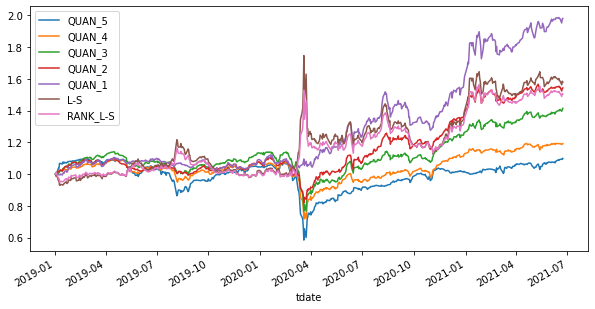

In [130]:
summ, ress = get_report(daily_score)

ress.plot(figsize = (10, 5))

summ

* 카나리아의 존재? --> 후보군 shift 후 공적분 구하기 or 머신러닝 도입?
* 매매 전략 추가 --> etf 특성을 활용
    * 괴리율 (1% 이상만) --> 가중치 부여
    * 섹터 --> 통계적 분석 필요, 매크로 혹은 일정 기준치 만족 시 가중치 부여
* 다 안된다면, PDF - 팩터 모델..? (크래프트)
* 리스크 모델? --> (i.e. 베타) and more risk indicators
* 베타의 경우:
    * Undervalued --> 소정의 가중치 부여
    * Largely overvalued --> 감점 요인

## 6. Identifying Canary

In [14]:
from statsmodels.tsa.stattools import coint

canary_cand_code = "A117690"
test_code = "A310970"
n_days = 2
def is_it_canary(canary_cand_code, test_code, n_days):
    canary_cand = etf_close[canary_cand_code].dropna(axis=0).shift(-n_days)
    canary_cand = canary_cand[target_start_date:target_end_date-timedelta(days=n_days)]
    
    test_on = etf_close[test_code]
    test_on = test_on[target_start_date:target_end_date-timedelta(days=n_days)]
    
    test_df = pd.concat([canary_cand, test_on], axis = 1)
    
    score, p_val, _ = coint(test_df[canary_cand_code], test_df[test_code])
    
    return p_val

test = is_it_canary(canary_cand_code, test_code, n_days)
test

0.03266722550191472

In [15]:
from statistics import geometric_mean

canary_cand_code = "A192090"
p_list = []
n_days = 7

for column_names in etf_close:
    flag = etf_close[column_names]
    flag = flag[target_start_date:target_start_date+timedelta(days=30)]

    if flag.isnull().values.any() or canary_cand_code == column_names:
        pass
    else:
        test_code = column_names
        p = is_it_canary(canary_cand_code, test_code, n_days)
        p_list.append(p)

geometric_mean(p_list)

0.2527907502071298

카나리아 종목: <br>
7일 기준: <br>
A117690 (TIGER 차이나항셍25) --> 0.021360090369094267 <br>
A245360 (TIGER 차이나HSCEI) --> 0.00251560364345244 <br>

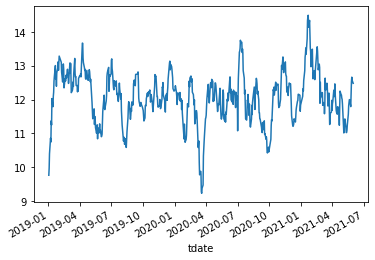

In [16]:
HS = daily_score["A117690"]
HS.plot()

## 6-1. Future Error Variance Decomposition

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import FEVD
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import adfuller

In [18]:
new1 = etf_close[target_start_date-timedelta(days=10):target_end_date]
for_fevd = new1.copy().dropna(axis=1)
for_fevd #.iloc[:,44]

etf_code,A091220,A091230,A098560,A102110,A105010,A114820,A117690,A123310,A123320,A130680,...,A300610,A302170,A302180,A302190,A305080,A305540,A307510,A307520,A310960,A310970
tdate,,,,,,,,,,,,,,,,,,,,,
2018-12-21,7935.0,17120.0,10135.0,26485.0,3665.0,109570.0,15715.0,7895.0,10530.0,3510.0,...,8105.0,49725.0,47885.0,51860.0,10225.0,8155.0,9685.0,11160.0,13245.0,9880.0
2018-12-24,7915.0,17360.0,10000.0,26500.0,3600.0,109495.0,15760.0,7890.0,10500.0,3480.0,...,8180.0,49745.0,47980.0,51785.0,10270.0,8055.0,9650.0,11070.0,13260.0,9955.0
2018-12-26,7720.0,17000.0,9850.0,26120.0,3590.0,109635.0,15900.0,8010.0,10205.0,3255.0,...,8010.0,49725.0,47795.0,51900.0,10300.0,8005.0,9570.0,10885.0,13075.0,9790.0
2018-12-27,7795.0,17485.0,9980.0,26480.0,3590.0,109650.0,14945.0,7900.0,10470.0,3495.0,...,8110.0,49710.0,47795.0,51920.0,10200.0,8130.0,9810.0,11035.0,13250.0,9940.0
2018-12-28,7870.0,17690.0,10225.0,26580.0,3610.0,109665.0,15025.0,7860.0,10610.0,3490.0,...,8130.0,49740.0,47845.0,51910.0,10195.0,8150.0,9885.0,11085.0,13345.0,10040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,7995.0,37140.0,9715.0,42535.0,3480.0,111045.0,17050.0,4220.0,26095.0,2990.0,...,12790.0,49720.0,48755.0,52160.0,11425.0,17550.0,18605.0,13050.0,22665.0,17170.0
2021-05-26,7955.0,37250.0,9830.0,42445.0,3410.0,111010.0,17280.0,4230.0,25975.0,2990.0,...,12875.0,49750.0,48695.0,52160.0,11395.0,17430.0,18675.0,13050.0,22610.0,17120.0
2021-05-27,7840.0,37745.0,9825.0,42315.0,3470.0,111150.0,17270.0,4230.0,25905.0,2980.0,...,12900.0,49730.0,48695.0,52230.0,11400.0,17510.0,18835.0,12835.0,22575.0,17060.0


In [19]:
data = np.log(for_fevd).diff().dropna() #To make it stationary using difference
model = VAR(data)

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [20]:
for column_names in data:    #Stationary Check
    adfuller_test = adfuller(data[column_names], autolag= "AIC")
    print(column_names)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))

A091220
ADF test statistic: -12.256186657128465
p-value: 9.298911223738644e-23
A091230
ADF test statistic: -25.019460148651238
p-value: 0.0
A098560
ADF test statistic: -13.946139412742102
p-value: 4.7935774649166404e-26
A102110
ADF test statistic: -15.060610363302068
p-value: 9.015986218432141e-28
A105010
ADF test statistic: -7.004484802652934
p-value: 7.180560067922518e-10
A114820
ADF test statistic: -7.550156107427182
p-value: 3.2046626088373585e-11
A117690
ADF test statistic: -24.311170374204714
p-value: 0.0
A123310
ADF test statistic: -15.324611327292345
p-value: 4.021153808665632e-28
A123320
ADF test statistic: -12.062254366395203
p-value: 2.453983873375116e-22
A130680
ADF test statistic: -6.706023564992762
p-value: 3.7833877572482464e-09
A133690
ADF test statistic: -13.04249254915412
p-value: 2.2262180268425163e-24
A137610
ADF test statistic: -9.759981975587582
p-value: 7.608707777842887e-17
A138520
ADF test statistic: -14.694595278320099
p-value: 3.0122360760385366e-27
A138530
A

In [21]:
def validation(canary_code, test_code, option):
    df = for_fevd[[canary_code, test_code]]
    data = np.log(df).diff().dropna()
    model = VAR(data)
    result = model.fit(2)
    irf = result.irf(2)
    fevd = result.fevd(5)
    if option == 'irf':
        res = irf
    elif option == 'fevd':
        res = fevd
    else:
        res = fevd
    return res

In [150]:
canary_code_t = 'A245360' # 'A245360' & 'A117690'
test_code_t = 'A123320'
option_t = 'fevd'

testt = validation(canary_code_t, test_code_t, option_t)
testt.summary()

FEVD for A245360
      A245360   A123320
0    1.000000  0.000000
1    0.982580  0.017420
2    0.981841  0.018159
3    0.981988  0.018012
4    0.981826  0.018174

FEVD for A123320
      A245360   A123320
0    0.276488  0.723512
1    0.282441  0.717559
2    0.350202  0.649798
3    0.351049  0.648951
4    0.351451  0.648549




/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [22]:
# Case 1: Canary --> A245360 & Check the FEVD
canary_code = 'A245360' # 'A245360' & 'A117690'
option = 'fevd'

for column_names in for_fevd:
    if column_names != canary_code:
        test_code = column_names
        ret = validation(canary_code, test_code, option)
        ret.summary()
    else:
        continue

FEVD for A245360
      A245360   A091220
0    1.000000  0.000000
1    0.997087  0.002913
2    0.981442  0.018558
3    0.979677  0.020323
4    0.979661  0.020339

FEVD for A091220
      A245360   A091220
0    0.149251  0.850749
1    0.176909  0.823091
2    0.225075  0.774925
3    0.226401  0.773599
4    0.226213  0.773787


FEVD for A245360
      A245360   A091230
0    1.000000  0.000000
1    0.984470  0.015530
2    0.971543  0.028457
3    0.971694  0.028306
4    0.971294  0.028706

FEVD for A091230
      A245360   A091230
0    0.229084  0.770916
1    0.230796  0.769204
2    0.281872  0.718128
3    0.283309  0.716691
4    0.285204  0.714796


FEVD for A245360
      A245360   A098560
0    1.000000  0.000000
1    0.993428  0.006572
2    0.993334  0.006666
3    0.993374  0.006626
4    0.993347  0.006653

FEVD for A098560
      A245360   A098560
0    0.148229  0.851771
1    0.149412  0.850588
2    0.194785  0.805215
3    0.194693  0.805307
4    0.194663  0.805337


FEVD for A245360
      A2

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A245360
      A245360   A139310
0    1.000000  0.000000
1    0.998362  0.001638
2    0.993536  0.006464
3    0.992765  0.007235
4    0.992716  0.007284

FEVD for A139310
      A245360   A139310
0    0.015383  0.984617
1    0.013935  0.986065
2    0.013933  0.986067
3    0.014419  0.985581
4    0.014481  0.985519


FEVD for A245360
      A245360   A139320
0    1.000000  0.000000
1    0.999740  0.000260
2    0.987676  0.012324
3    0.986745  0.013255
4    0.986712  0.013288

FEVD for A139320
      A245360   A139320
0    0.012300  0.987700
1    0.013749  0.986251
2    0.034411  0.965589
3    0.036142  0.963858
4    0.036154  0.963846


FEVD for A245360
      A245360   A143850
0    1.000000  0.000000
1    0.983475  0.016525
2    0.983035  0.016965
3    0.983019  0.016981
4    0.982881  0.017119

FEVD for A143850
      A245360   A143850
0    0.075235  0.924765
1    0.079769  0.920231
2    0.158993  0.841007
3    0.163569  0.836431
4    0.163987  0.836013


FEVD for A245360
      A2

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A245360
      A245360   A227550
0    1.000000  0.000000
1    0.998630  0.001370
2    0.998154  0.001846
3    0.998080  0.001920
4    0.998080  0.001920

FEVD for A227550
      A245360   A227550
0    0.117110  0.882890
1    0.117741  0.882259
2    0.182780  0.817220
3    0.184797  0.815203
4    0.184964  0.815036


FEVD for A245360
      A245360   A227560
0    1.000000  0.000000
1    0.988500  0.011500
2    0.982764  0.017236
3    0.982762  0.017238
4    0.982716  0.017284

FEVD for A227560
      A245360   A227560
0    0.210747  0.789253
1    0.212780  0.787220
2    0.232922  0.767078
3    0.234253  0.765747
4    0.234225  0.765775


FEVD for A245360
      A245360   A227570
0    1.000000  0.000000
1    0.993021  0.006979
2    0.992969  0.007031
3    0.993015  0.006985
4    0.992977  0.007023

FEVD for A227570
      A245360   A227570
0    0.290898  0.709102
1    0.299492  0.700508
2    0.361298  0.638702
3    0.361030  0.638970
4    0.361159  0.638841


FEVD for A245360
      A2

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A245360
      A245360   A275980
0    1.000000  0.000000
1    0.947132  0.052868
2    0.939740  0.060260
3    0.940626  0.059374
4    0.939761  0.060239

FEVD for A275980
      A245360   A275980
0    0.162159  0.837841
1    0.171745  0.828255
2    0.243833  0.756167
3    0.245610  0.754390
4    0.246421  0.753579


FEVD for A245360
      A245360   A276000
0    1.000000  0.000000
1    0.993512  0.006488
2    0.961945  0.038055
3    0.960178  0.039822
4    0.960159  0.039841

FEVD for A276000
      A245360   A276000
0    0.118447  0.881553
1    0.124177  0.875823
2    0.125490  0.874510
3    0.125657  0.874343
4    0.125747  0.874253


FEVD for A245360
      A245360   A277630
0    1.000000  0.000000
1    0.987541  0.012459
2    0.987581  0.012419
3    0.987631  0.012369
4    0.987541  0.012459

FEVD for A277630
      A245360   A277630
0    0.311110  0.688890
1    0.316098  0.683902
2    0.374316  0.625684
3    0.374622  0.625378
4    0.374622  0.625378


FEVD for A245360
      A2

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

**Case 1 해석:** <br>

5일 Lag <br>

영향을 가장 안 받는 종목: <br>
0.05 이하: <br>
1. A137610 --> 0.024041
2. A139310 --> 0.014481
3. A139320 --> 0.036154
4. A157450 --> 0.006419
5. A160580 --> 0.038145
6. A182490 --> 0.045953
7. A203780 --> 0.045868
8. A248270 --> 0.019509
9. A272580 --> 0.007104
10. A302180 --> 0.040803
11. A302190 --> 0.038064

영향을 가장 많이 받는 종목: <br>
0.3 이상: <br>
1. A102110 --> 0.344941
2. A123310 --> 0.356773
3. A123320 --> 0.351451
4. A138520 --> 0.308615
5. A139220 --> 0.310751
6. A139250 --> 0.374828
7. A139260 --> 0.318354
8. A147970 --> 0.364944
9. A157500 --> 0.335794
10. A166400 --> 0.314820
11. A174350 --> 0.346768
12. A210780 --> 0.339022
13. A211560 --> 0.403102
14. A217790 --> 0.369780
15. A227570 --> 0.361159
16. A228820 --> 0.303069
17. A243880 --> 0.322923
18. A243890 --> 0.390550
19. A252710 --> 0.352655
20. A267770 --> 0.358803
21. A277630 --> 0.374622
22. A277640 --> 0.341050
23. A289480 --> 0.303280
24. A292160 --> 0.327717
25. A305540 --> 0.341877
26. A310960 --> 0.346259
27. A310970 --> 0.348908

In [23]:
# Case 2: Canary --> A117690 & Check the FEVD
canary_code = 'A117690' # 'A245360' & 'A117690'
option = 'fevd'

for column_names in for_fevd:
    if column_names != canary_code:
        test_code = column_names
        ret = validation(canary_code, test_code, option)
        ret.summary()
    else:
        continue

FEVD for A117690
      A117690   A091220
0    1.000000  0.000000
1    0.998720  0.001280
2    0.994801  0.005199
3    0.994796  0.005204
4    0.994718  0.005282

FEVD for A091220
      A117690   A091220
0    0.093598  0.906402
1    0.092862  0.907138
2    0.092905  0.907095
3    0.092864  0.907136
4    0.092861  0.907139


FEVD for A117690
      A117690   A091230
0    1.000000  0.000000
1    0.999910  0.000090
2    0.999798  0.000202
3    0.999798  0.000202
4    0.999798  0.000202

FEVD for A091230
      A117690   A091230
0    0.213268  0.786732
1    0.214249  0.785751
2    0.215986  0.784014
3    0.215985  0.784015
4    0.215989  0.784011


FEVD for A117690
      A117690   A098560
0    1.000000  0.000000
1    1.000000  0.000000
2    0.994972  0.005028
3    0.994958  0.005042
4    0.994786  0.005214

FEVD for A098560
      A117690   A098560
0    0.098379  0.901621
1    0.100856  0.899144
2    0.101534  0.898466
3    0.101665  0.898335
4    0.101696  0.898304


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A117690
      A117690   A123320
0    1.000000  0.000000
1    0.999945  0.000055
2    0.999382  0.000618
3    0.999375  0.000625
4    0.999357  0.000643

FEVD for A123320
      A117690   A123320
0    0.240581  0.759419
1    0.240050  0.759950
2    0.239334  0.760666
3    0.239270  0.760730
4    0.239243  0.760757


FEVD for A117690
      A117690   A130680
0    1.000000  0.000000
1    0.999729  0.000271
2    0.999023  0.000977
3    0.999007  0.000993
4    0.999004  0.000996

FEVD for A130680
      A117690   A130680
0    0.090116  0.909884
1    0.089976  0.910024
2    0.090026  0.909974
3    0.090047  0.909953
4    0.090049  0.909951


FEVD for A117690
      A117690   A133690
0    1.000000  0.000000
1    0.997464  0.002536
2    0.997455  0.002545
3    0.997453  0.002547
4    0.997453  0.002547

FEVD for A133690
      A117690   A133690
0    0.181261  0.818739
1    0.179441  0.820559
2    0.180576  0.819424
3    0.180537  0.819463
4    0.180536  0.819464


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A117690
      A117690   A138540
0    1.000000  0.000000
1    0.999703  0.000297
2    0.997506  0.002494
3    0.997506  0.002494
4    0.997470  0.002530

FEVD for A138540
      A117690   A138540
0    0.111671  0.888329
1    0.114525  0.885475
2    0.116197  0.883803
3    0.116271  0.883729
4    0.116301  0.883699


FEVD for A117690
      A117690   A139220
0    1.000000  0.000000
1    0.999997  0.000003
2    0.999752  0.000248
3    0.999752  0.000248
4    0.999748  0.000252

FEVD for A139220
      A117690   A139220
0    0.123031  0.876969
1    0.128311  0.871689
2    0.130000  0.870000
3    0.130068  0.869932
4    0.130090  0.869910


FEVD for A117690
      A117690   A139230
0    1.000000  0.000000
1    0.999736  0.000264
2    0.999737  0.000263
3    0.999733  0.000267
4    0.999733  0.000267

FEVD for A139230
      A117690   A139230
0    0.129966  0.870034
1    0.135918  0.864082
2    0.135357  0.864643
3    0.135426  0.864574
4    0.135423  0.864577


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A117690
      A117690   A182480
0    1.000000  0.000000
1    0.999160  0.000840
2    0.998180  0.001820
3    0.998147  0.001853
4    0.998126  0.001874

FEVD for A182480
      A117690   A182480
0    0.055552  0.944448
1    0.062358  0.937642
2    0.063483  0.936517
3    0.063663  0.936337
4    0.063690  0.936310


FEVD for A117690
      A117690   A182490
0    1.000000  0.000000
1    0.994762  0.005238
2    0.994621  0.005379
3    0.994249  0.005751
4    0.994234  0.005766

FEVD for A182490
      A117690   A182490
0    0.006131  0.993869
1    0.037709  0.962291
2    0.037750  0.962250
3    0.039532  0.960468
4    0.039508  0.960492


FEVD for A117690
      A117690   A192090
0    1.000000  0.000000
1    0.997765  0.002235
2    0.996739  0.003261
3    0.996707  0.003293
4    0.996707  0.003293

FEVD for A192090
      A117690   A192090
0    0.393228  0.606772
1    0.392419  0.607581
2    0.395789  0.604211
3    0.395741  0.604259
4    0.395741  0.604259


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A117690
      A117690   A210780
0    1.000000  0.000000
1    0.999532  0.000468
2    0.999284  0.000716
3    0.999260  0.000740
4    0.999247  0.000753

FEVD for A210780
      A117690   A210780
0    0.129670  0.870330
1    0.134502  0.865498
2    0.135429  0.864571
3    0.135632  0.864368
4    0.135667  0.864333


FEVD for A117690
      A117690   A211560
0    1.000000  0.000000
1    0.999942  0.000058
2    0.999317  0.000683
3    0.999310  0.000690
4    0.999274  0.000726

FEVD for A211560
      A117690   A211560
0    0.174623  0.825377
1    0.178667  0.821333
2    0.176530  0.823470
3    0.176683  0.823317
4    0.176567  0.823433


FEVD for A117690
      A117690   A217770
0    1.000000  0.000000
1    0.999873  0.000127
2    0.995082  0.004918
3    0.995056  0.004944
4    0.995056  0.004944

FEVD for A217770
      A117690   A217770
0    0.048096  0.951904
1    0.047839  0.952161
2    0.048443  0.951557
3    0.048449  0.951551
4    0.048449  0.951551


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A117690
      A117690   A250780
0    1.000000  0.000000
1    0.999993  0.000007
2    0.999989  0.000011
3    0.999989  0.000011
4    0.999989  0.000011

FEVD for A250780
      A117690   A250780
0    0.177384  0.822616
1    0.177518  0.822482
2    0.177636  0.822364
3    0.177638  0.822362
4    0.177638  0.822362


FEVD for A117690
      A117690   A252000
0    1.000000  0.000000
1    0.999471  0.000529
2    0.999421  0.000579
3    0.999404  0.000596
4    0.999403  0.000597

FEVD for A252000
      A117690   A252000
0    0.163508  0.836492
1    0.181380  0.818620
2    0.181475  0.818525
3    0.182070  0.817930
4    0.182078  0.817922


FEVD for A117690
      A117690   A252710
0    1.000000  0.000000
1    0.999979  0.000021
2    0.998996  0.001004
3    0.998994  0.001006
4    0.998966  0.001034

FEVD for A252710
      A117690   A252710
0    0.240183  0.759817
1    0.239411  0.760589
2    0.238583  0.761417
3    0.238523  0.761477
4    0.238496  0.761504


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A

FEVD for A117690
      A117690   A307510
0    1.000000  0.000000
1    0.999946  0.000054
2    0.996030  0.003970
3    0.996010  0.003990
4    0.995969  0.004031

FEVD for A307510
      A117690   A307510
0    0.048952  0.951048
1    0.049922  0.950078
2    0.050020  0.949980
3    0.050030  0.949970
4    0.050031  0.949969


FEVD for A117690
      A117690   A307520
0    1.000000  0.000000
1    0.999774  0.000226
2    0.998540  0.001460
3    0.998524  0.001476
4    0.998515  0.001485

FEVD for A307520
      A117690   A307520
0    0.110643  0.889357
1    0.120065  0.879935
2    0.121341  0.878659
3    0.121453  0.878547
4    0.121467  0.878533


FEVD for A117690
      A117690   A310960
0    1.000000  0.000000
1    0.999949  0.000051
2    0.999529  0.000471
3    0.999523  0.000477
4    0.999509  0.000491

FEVD for A310960
      A117690   A310960
0    0.241244  0.758756
1    0.240632  0.759368
2    0.240070  0.759930
3    0.239998  0.760002
4    0.239974  0.760026


FEVD for A117690
      A1

/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/inbum/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


**Case 2 해석:** <br>

영향을 가장 안 받는 종목: <br>
0.05 이하: <br>
1. A114820 --> 0.010853
2. A137610 --> 0.014103
3. A139310 --> 0.020352
4. A139320 --> 0.003765
5. A157450 --> 0.038848
6. A160580 --> 0.028705
7. A182490 --> 0.039508
8. A217770 --> 0.048449
9. A248260 --> 0.027961
10. A272580 --> 0.041190
11. A302170 --> 0.012598
12. A302180 --> 0.020385
13. A302190 --> 0.005360

Case 1 + 2: <br>
둘 다 공통적으로 포함되는 종목: <br>

- A137610: TIGER 농산물선물Enhanced(H)
- A139310: TIGER 금속선물(H)
- A139320: TIGER 금은선물(H)
- A157450: TIGER 단기통안채
- A160580: TIGER 구리실물
- A182490: TIGER 단기선진하이일드(합성 H)
- A272580: TIGER 단기채권액티브
- A302180: TIGER 국채선물10년인버스
- A302190: TIGER 중장기국채

## 7. 카나리아 전략 백테스팅

방어 종목 --> 실제 하락장 기간에 검증을 하기 보다는 (lookahead bias) 이론을 베이스로 선정 <br>
- A302190: TIGER 중장기국채
- A237440: TIGER 경기방어채권혼합
- A319640: TIGER 골드선물(H)
- A305080: TIGER 미국채10년선물

인버스 종목 <br>
- A217770: TIGER 원유선물인버스(H)
- A252710: TIGER 200선물인버스2X
- A123310: TIGER 인버스
- A250780: TIGER 코스닥150선물인버스

공격 종목 <br>
- A233160: TIGER 코스닥150 레버리지
- A123320: TIGER 레버리지
- A204480: TIGER 차이나CSI300레버리지(합성)
- A225040: TIGER 미국S&P500레버리지(합성 H)
- A225060: TIGER 이머징마켓MSCI레버리지(합성 H)

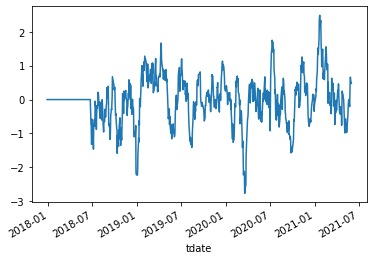

In [151]:
defensive_etf = ["A174350", "A302190", "A237440", "A319640", "A305080"]
#방어 종목 선정 기준 강화 필요
inverse_etf = ["A217770", "A252710", "A123310"]
canary_etf = ["A117690", "A245360"]

# 카나리아 둘다 모멘텀이 0.5 이하 --> 방어 자산군에 가중치 부여
# 카나리아 둘다 모멘텀이 -1 이하 --> 인버스 및 방어 자산군에 가중치 부여
def DAA(x):
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before2w = new[x.name-timedelta(days=20):x.name-timedelta(days=15)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1] 
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1) 
        
        if momentum["A117690"] < -1 or momentum["A245360"] < -1:
            momentum["A302190"] += 2
            momentum["A237440"] += 2
            momentum["A319640"] += 2
            momentum["A250780"] += 2
#             if momentum["A117690"] < -1 or momentum["A245360"] < -1:
#                 momentum["A217770"] += 3
#                 momentum["A252710"] += 3
#                 momentum["A123310"] += 3
#                 momentum["A123310"] += 3
#         elif momentum["A117690"] > 0.75 and momentum["A245360"] > 0.75:
#             momentum["A233160"] += 2
#             momentum["A123320"] += 2
#             momentum["A204480"] += 2
#             momentum["A225040"] += 2
#             momentum["A225060"] += 2
            
    except:
        pass
    return momentum
    
score = new.apply(lambda x: DAA(x), axis=1)
daily_score2 = score[target_start_date:target_end_date]

weekly_score2 = score.resample('W').last()
weekly_score2 = weekly_score2[target_start_date:target_end_date]

monthly_score2 = score.resample('M').last()
monthly_score2 = monthly_score2[target_start_date:target_end_date]

score["A117690"].plot()

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,1.098714,1.191651,1.414070,1.542046,1.979577,1.578434,1.504064
MDD,-0.466090,-0.344968,-0.328239,-0.256233,-0.159028,-0.354181,-0.258961
TURNOVER,104.694036,221.848345,250.382145,228.399684,103.743032,208.437068,169.535752
CAGR,0.031878,0.060188,0.122424,0.155311,0.255618,0.164328,0.145747
SHARPE,0.062202,0.115741,0.203394,0.266979,0.355845,0.169765,0.180014


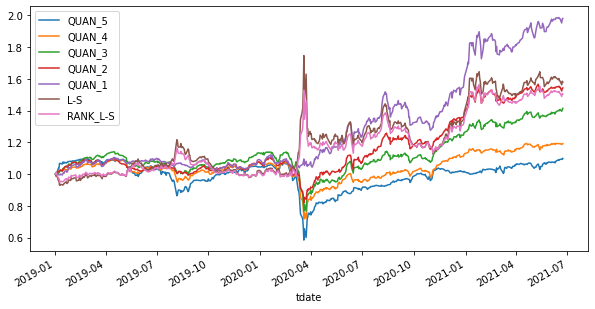

In [152]:
summ, ress = get_report(daily_score2)

ress.plot(figsize = (10, 5))

summ

20210827

1. 방어 (공격) 종목은 이론을 근간으로 선정, 허나 추후에 통계적인 검증을 통해 선정할 수 있겠지만 lookahead bias 의 가능성, 또한 이론을 근간으로 선정한다고 해도 이번꺼는 되게 rough 하게 선정함 조금 더 명확한 이론적인 기준을 가지고 선정 해야함
2. 아무래도 카나리아 전략 같은 경우에는 즉각적인 대처를 요하기에, 기존의 모멘텀 공식을 변형, 단기 모멘텀 (2주)을 추가해서 비중을 늘림 --> 퍼포먼스 크게 개선 주간, 월간 리밸런싱에도 긍정적으로 영향을 미침. +지난번 모멘텀 공식에 카나리아 전략을 동일하게 적용했을 때는 return 이 7% 가량 증가 +변화된 공식을 적용했을때는 30% 가량 증가, 확실히 하락도 잘 방어함
3. 분산/분해 단기적인 관점 (카나리아)

In [153]:
#Modified Ver.

defensive_etf = ["A137610", "A139310", "A139320", "A157450", "A160580", "A182490", "A272580", "A302180", "A302190"]
#방어 종목 선정 기준 강화 필요
inverse_etf = ["A217770", "A252710", "A123310"]
canary_etf = ["A117690", "A245360"]

# 카나리아 둘다 모멘텀이 0.5 이하 --> 방어 자산군에 가중치 부여
# 카나리아 둘다 모멘텀이 -1 이하 --> 인버스 및 방어 자산군에 가중치 부여
def DAA2(x):
    code_ls = new.columns.values.tolist()
    momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    canary_momentum = pd.Series(np.zeros(len(code_ls)).tolist(), index=code_ls)
    try: 
        before5d = new[x.name-timedelta(days=5):x.name-timedelta(days=1)].iloc[-1] 
        before2w = new[x.name-timedelta(days=19):x.name-timedelta(days=14)].iloc[-1] 
        before1 = new[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1] 
        before3 = new[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1] 
        before6 = new[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1]
        momentum = 12 * (x / before2w - 1) + 6 * (x / before1 - 1) + 2 * (x / before3 - 1) + (x / before6 - 1)  

        canary_momentum = ((x - before5d) / before5d)
                
        if canary_momentum["A117690"] < -0.025 or canary_momentum["A245360"] < -0.025:
            momentum["A302190"] += 2
            momentum["A237440"] += 2
            momentum["A319640"] += 2
            momentum["A250780"] += 2
#             momentum["A182490"] += 0.5
#             momentum["A272580"] += 0.5
#             momentum["A302180"] += 0.5
#             momentum["A302190"] += 0.5
#             if momentum["A117690"] < -1 and momentum["A245360"] < -1:
#                 momentum["A137610"] += 0.3
#                 momentum["A139310"] += 0.3
#                 momentum["A139320"] += 0.3
#                 momentum["A157450"] += 0.3
#                 momentum["A160580"] += 0.3
#                 momentum["A182490"] += 0.3
#                 momentum["A272580"] += 0.3
#                 momentum["A302180"] += 0.3
#                 momentum["A302190"] += 0.3
#         elif momentum["A117690"] > 1.5 and momentum["A245360"] > 1.5:
#             momentum["A233160"] += 1
#             momentum["A123320"] += 1
#             momentum["A204480"] += 1
#             momentum["A225040"] += 1
#             momentum["A225060"] += 1
            
    except:
        pass
    
    return momentum
    
score2 = new.apply(lambda x: DAA2(x), axis=1)
daily_score3 = score2[target_start_date:target_end_date]

weekly_score3 = score2.resample('W').last()
weekly_score3 = weekly_score3[target_start_date:target_end_date]

monthly_score3 = score2.resample('M').last()
monthly_score3 = monthly_score3[target_start_date:target_end_date]

,QUAN_5,QUAN_4,QUAN_3,QUAN_2,QUAN_1,L-S,RANK_L-S
RETURN,1.126306,1.203506,1.378276,1.647023,1.848830,1.434134,1.417711
MDD,-0.463467,-0.348691,-0.334522,-0.248190,-0.169642,-0.405941,-0.296217
TURNOVER,109.912682,230.892537,257.283448,233.797106,110.826225,220.738907,179.003826
CAGR,0.040444,0.063693,0.112873,0.180955,0.227342,0.127708,0.123387
SHARPE,0.071792,0.119577,0.192003,0.305671,0.325724,0.140838,0.158387


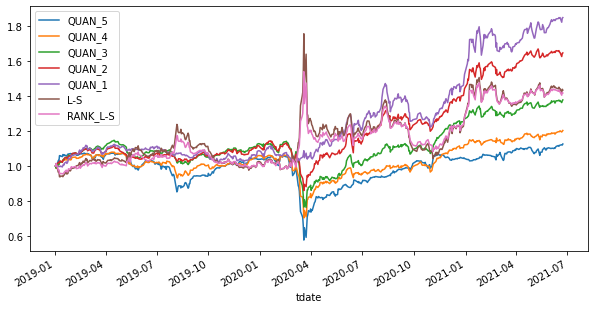

In [154]:
summ, ress = get_report(daily_score3)

ress.plot(figsize = (10, 5))

summ

1. 카나리아가 단기적으로 급락이 나왔을 경우에 따른 조건부 방어 자산군에 가중치를 부여하여야함
2. 카나리아의 모멘텀이 좋을 경우 레버리지 활용
3. 방어 자산군을 찾아야함 (제대로) --> 경기 방어
4. 제대로 Implement 하여야함